In [3]:
import torch
import torch.nn as nn             # to load all neural net functionality
import torch.nn.functional as F          # adds some efficiency
from torch.utils.data import DataLoader  # lets us load data in batches
from torchvision import datasets, transforms
import sklearn
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix # for evaluating results
import matplotlib.pyplot as plt
%matplotlib inline
import time
torch.manual_seed(101)  # for consistent results

In [5]:
Transform = transforms.ToTensor()
train = datasets.MNIST(root='../DATA', train=True, download=True, transform=Transform)
train


Extracting ../DATA/MNIST/raw/train-images-idx3-ubyte.gz to ../DATA/MNIST/raw




Extracting ../DATA/MNIST/raw/train-labels-idx1-ubyte.gz to ../DATA/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../DATA/MNIST/raw/t10k-images-idx3-ubyte.gz to ../DATA/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../DATA/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../DATA/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Dataset MNIST
    Number of datapoints: 60000
    Root location: ../DATA
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
test = datasets.MNIST(root='../DATA', train=False, download=False, transform=Transform)
test

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../DATA
    Split: Test
    StandardTransform
Transform: ToTensor()

The train data has 60,000 images and test has 10,000. Let's take a look at one.

In [10]:
image, label = train[0]
print('Shape:', image.shape, '\nLabel:', label)

Shape: torch.Size([1, 28, 28]) 
Label: 5


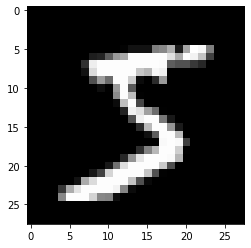

In [11]:
plt.imshow(image.reshape((28,28)), cmap="gray")

In [12]:
train_loader = DataLoader(train, batch_size=100, shuffle=True)

test_loader = DataLoader(test, batch_size=500, shuffle=False)

### Time to define our model !


In [13]:
class MultilayerPerceptron(nn.Module):
    def __init__(self, input_size=784, output_size=10, layers=[120,84]):
        super().__init__()
        self.d1 = nn.Linear(input_size,layers[0])  #hidden layer 1
        self.d2 = nn.Linear(layers[0],layers[1])   # hidden layer 2
        self.d3 = nn.Linear(layers[1],output_size)  # output layer
    
    def forward(self,X):
        X = F.relu(self.d1(X))
        X = F.relu(self.d2(X))
        X = self.d3(X)
        return F.log_softmax(X, dim=1)

In [14]:
model = MultilayerPerceptron()
print(model)

MultilayerPerceptron(
  (d1): Linear(in_features=784, out_features=120, bias=True)
  (d2): Linear(in_features=120, out_features=84, bias=True)
  (d3): Linear(in_features=84, out_features=10, bias=True)
)


In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [16]:
for images, labels in train_loader:
    print('Initial Batch shape:', images.size())
    break
print('Batch shape after flattening',images.view(100,-1).size())

Initial Batch shape: torch.Size([100, 1, 28, 28])
Batch shape after flattening torch.Size([100, 784])


In [17]:
epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(X_train.view(100, -1))  # Here we flatten X_train
        loss = criterion(y_pred, y_train)
 
        # Calculate the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1] # the prediction that has the maximum probability
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad() # reset the gradients after each training step
        loss.backward() #to trigger backprop
        optimizer.step() #perform parameter update 
        
        # Print interim results
        if b%600 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{100*b:6}/60000] Train loss: {loss.item():10.8f}  Train accuracy: {trn_corr.item()*100/(100*b):7.3f}%')
    
    # Update train loss & accuracy for the epoch
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():   # don't calculate gradients during testing
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test.view(500, -1))  # Here we flatten X_test

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
    
    # Update test loss & accuracy for the epoch
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

epoch:  0  batch:  600 [ 60000/60000] Train loss: 0.22855240  Train accuracy:  89.947%
epoch:  1  batch:  600 [ 60000/60000] Train loss: 0.10864811  Train accuracy:  95.378%
epoch:  2  batch:  600 [ 60000/60000] Train loss: 0.14619465  Train accuracy:  96.838%
epoch:  3  batch:  600 [ 60000/60000] Train loss: 0.10701600  Train accuracy:  97.612%
epoch:  4  batch:  600 [ 60000/60000] Train loss: 0.06019892  Train accuracy:  98.067%
epoch:  5  batch:  600 [ 60000/60000] Train loss: 0.04505363  Train accuracy:  98.507%
epoch:  6  batch:  600 [ 60000/60000] Train loss: 0.04958494  Train accuracy:  98.680%
epoch:  7  batch:  600 [ 60000/60000] Train loss: 0.03049167  Train accuracy:  98.925%
epoch:  8  batch:  600 [ 60000/60000] Train loss: 0.13843191  Train accuracy:  99.068%
epoch:  9  batch:  600 [ 60000/60000] Train loss: 0.01358684  Train accuracy:  99.322%


In [20]:
print(f'Test accuracy: {test_correct[-1].item()*100/10000:.3f}%') # test accuracy 

Test accuracy: 97.830%


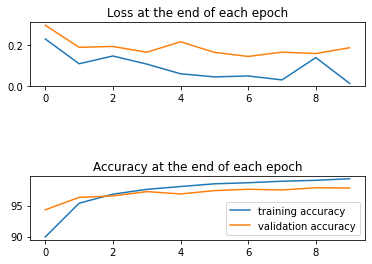

In [19]:
plt.subplot(3, 1, 1)
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')

plt.subplot(3, 1, 3)
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')

plt.legend()